In [5]:
import numpy as np
from scipy.interpolate import interp1d
from simpegem1d import EM1DAnalytics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
type(np.nan)

float

In [20]:
from simpegem1d import transFiltImpulse, transFilt, setFrequency, HzanalCirc
from scipy.constants import mu_0
from scipy.interpolate import interp1d
from scipy.signal import butter, freqz

def butter_lowpass(highcut_frequency, fs=1e6, period=0.04, order=1):
    """
    Butterworth low pass filter
    
    Parameters
    ----------
    
    highcut_frequency: float
        high-cut frequency for the low pass filter
    fs: float
        sampling rate, 1./ dt, (default = 1MHz) 
    period: 
        period of the signal (e.g. 25Hz base frequency, 0.04s)
    order: int
        The order of the butterworth filter
    
    Returns
    -------
    
    frequency, h: ndarray, ndarray
        Filter values (`h`) at frequencies (`frequency`) are provided.
    """
    # Nyquist frequency
    nyq = 0.5 * fs
    n_samples = period * fs    
    high = highcut_frequency / nyq
    b, a = butter(order, high, btype='low')
    w, h = freqz(b, a, worN=int(n_samples))
    frequency = (fs * 0.5 / np.pi) * w
    
    return frequency, h

def dBzdtAnalCircTCole(a, t, sigma, highcut_frequency=None):

    wt, tbase, omega_int = setFrequency(t)
    hz = HzanalCirc(sigma, omega_int/2/np.pi, 1., a, 'secondary')
    # Treatment for inaccuracy in analytic solutions
    ind = omega_int < 0.2
    hz[ind] = 0.
    if highcut_frequency is not None:
        frequency, values = butter_lowpass(highcut_frequency)
        lowpass_func = interp1d(frequency*2*pi, values, fill_value='extrapolate')
        lowpass_filter = lowpass_func(omega_int)
        hz *= lowpass_filter
        
    dhzdtTD = -transFiltImpulse(hz, wt, tbase, omega_int, t)
    lowpass_resp = -transFiltImpulse(lowpass_filter, wt, tbase, omega_int, t)    

    return dhzdtTD*mu_0, lowpass_resp

In [21]:
freq, h = butter_lowpass(5e3)

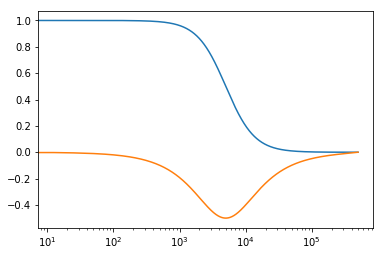

In [22]:
plt.semilogx(freq, h.real)
plt.semilogx(freq, h.imag)

In [12]:
time = np.logspace(-5, -2, 61)

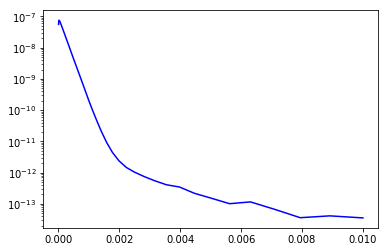

In [29]:
plt.semilogy(time, -out_temp, 'b')

In [32]:
out_temp, filter_temp = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=1e2)

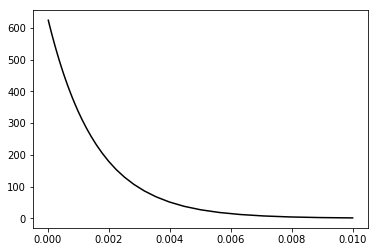

In [33]:
plt.plot(time, -filter_temp, 'k')

In [14]:
sigma = 1e-3
out_lowpass_10k = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=1e4)
out_lowpass_70k = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=7e4)
out_lowpass_100k = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=1e5)
out_lowpass_210k = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=210*1e3)
out = dBzdtAnalCircTCole(13., time, sigma, highcut_frequency=None)

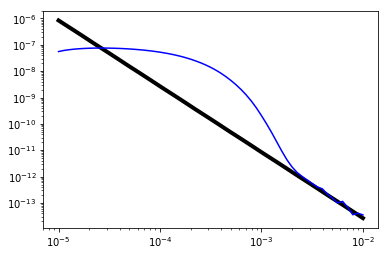

In [19]:
plt.loglog(time, -out, 'k-', lw=4)
plt.loglog(time, -out_temp, 'b')
plt.loglog(time, out_temp, 'b--')

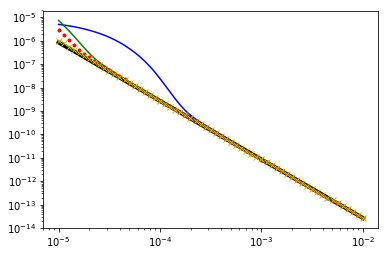

In [34]:
plt.loglog(time, -out, 'k-', lw=4)
plt.loglog(time, -out_lowpass_10k, 'b')
plt.loglog(time, -out_lowpass_70k, 'g')
plt.loglog(time, -out_lowpass_100k, 'r.')
plt.loglog(time, -out_lowpass_210k, 'yx')

In [539]:
def v_step(time):
    return EM1DAnalytics.dBzdtAnalCircTCole(
    10., time, 1e-2
    )

In [540]:
from scipy.integrate import fixed_quad, quadrature
t0 = 1e-3

In [541]:
time = np.logspace(-4, -2, 21)

In [542]:
from simpegem1d import skytem_HM_2015
wave = skytem_HM_2015()

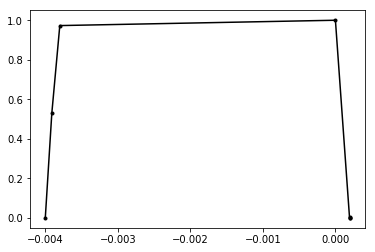

In [543]:
plt.plot(wave.current_times[-7:], wave.currents[-7:], 'k.-')

In [544]:
wave.current_times[-7:].max() * 1e3

0.196368

In [545]:
t0s = np.diff(wave.currents[-7:]) / np.diff(wave.current_times[-7:])
Tp = wave.current_times[-7:].max()-wave.current_times[-7:].min()

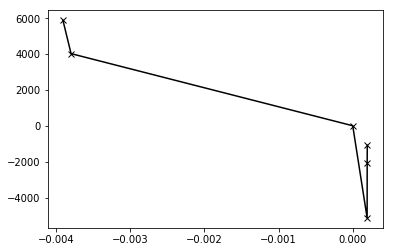

In [546]:
plt.plot(wave.current_times[-7:][1:], t0s, 'kx-')

In [547]:
from scipy.integrate import fixed_quad
step_func = v_step_exp
# T = 1./25.
t_off = np.logspace(-5, -2, 31)
t_currents = np.r_[0., 0.002, 0.004]
T = t_currents.max()
currents = np.r_[0., 1., 0.]

def piecewise_ramp(step_func, t_off, t_currents, currents, n=20, eps=1e-10):
    """
    Computes response from piecewise linear current waveform with a single pulse.
    This basically evaluates the convolution between dI/dt and step-off response.
    
    step_func: function handle to evaluate step-off response
    t_off: time channels when the current is off
    currents: input source currents
    n: Gaussian quadrature order
    """
    dt = np.diff(t_currents)
    dI = np.diff(currents)
    dIdt = dI/dt
    nt = t_currents.size
    response = np.zeros(t_off.size, dtype=float)
    pulse_time = t_currents.max()
    
    for i in range(1, nt):
        t_lag = pulse_time - t_currents[i]
        time = t_lag + t_off
        t0 = dt[i-1]
        const = -dIdt[i-1]
        if abs(const) > eps:
            response += np.array([fixed_quad(step_func, t, t+t0, n=20)[0] for t in time]) * const        
    return response

def double_pulse(step_func, t_off, t_currents, currents, T, n=20):
    """
    Computes response from double pulses (negative then positive)
    T: Period (e.g. 25 Hz base frequency, 0.04 s period)    
    """
    response_double = (
        piecewise_ramp(step_func, t_off, t_currents, currents, n=n)
        -piecewise_ramp(step_func, t_off+T/2., t_currents, currents, n=n) * 0.5
    )
    return response_double

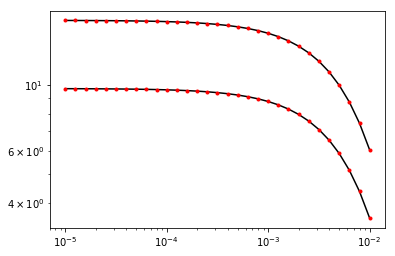

In [548]:
# single pulse
response_single = piecewise_ramp(v_step_exp, t_off, t_currents, currents)
response_single_true = v_ramp_off_exp(t_off, 2e-3)-v_ramp_off_exp(t_off+0.002, 2e-3)
# double pulse
response_double = double_pulse(v_step_exp, t_off, t_currents, currents, T)

response_double_true = (
    v_ramp_off_exp(t_off, 2e-3)-v_ramp_off_exp(t_off+0.002, 2e-3)+
    -(v_ramp_off_exp(t_off+T/2., 2e-3)-v_ramp_off_exp(t_off+0.002+T/2, 2e-3)) * 0.5
)
plt.loglog(t_off, response_double, 'k')
plt.loglog(t_off, response_double_true, 'r.')

plt.loglog(t_off, response_single, 'k')
plt.loglog(t_off, response_single_true, 'r.')

In [549]:
%%time
response_single = piecewise_ramp(v_step_l, t_off, t_currents, currents)

CPU times: user 1.6 ms, sys: 22 µs, total: 1.62 ms
Wall time: 1.61 ms


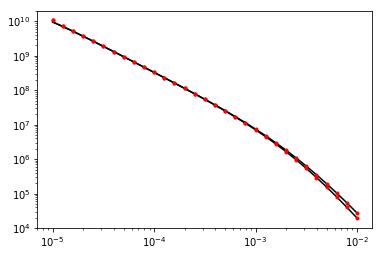

In [550]:
# single pulse
response_single = piecewise_ramp(v_step_l, t_off, t_currents, currents)
response_single_true = v_ramp_off_l(t_off, 2e-3)-v_ramp_off_l(t_off+0.002, 2e-3)
# double pulse
response_double = double_pulse(v_step_l, t_off, t_currents, currents, T)
response_double_true = (
    v_ramp_off_l(t_off, 2e-3)-v_ramp_off_l(t_off+0.002, 2e-3)+
    -(v_ramp_off_l(t_off+T/2., 2e-3)-v_ramp_off_l(t_off+0.002+T/2, 2e-3)) * 0.5
)
plt.loglog(t_off, response_double, 'k')
plt.loglog(t_off, response_double_true, 'r.')

plt.loglog(t_off, response_single, 'k')
plt.loglog(t_off, response_single_true, 'r.')

In [551]:
%%time
response_single_true = piecewise_ramp(v_step, t_off, t_currents, currents, n=5)


CPU times: user 323 ms, sys: 3.09 ms, total: 326 ms
Wall time: 330 ms


In [552]:
%%time
response_single_true = piecewise_ramp(v_step, t_off, t_currents, currents, n=20)


CPU times: user 358 ms, sys: 4.72 ms, total: 363 ms
Wall time: 399 ms


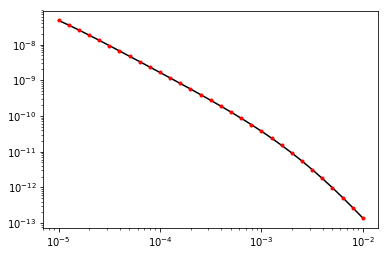

In [553]:
# single pulse
response_single = piecewise_ramp(v_step, t_off, t_currents, currents, n=20)

plt.loglog(t_off, -response_single, 'k')
plt.loglog(t_off, -response_single_true, 'r.')